In [1]:
import pandas as pd
import numpy as np
import seaborn               as sns
import matplotlib.pyplot     as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import MinMaxScaler, StandardScaler
from sklearn.base            import TransformerMixin
from sklearn.pipeline        import Pipeline, FeatureUnion
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
German = './input/german.data'
feature_names = ['CurrentAcc', 'NumMonths', 'CreditHistory', 'Purpose', 'CreditAmount', 
         'Savings', 'EmployDuration', 'PayBackPercent', 'Gender', 'Debtors', 
         'ResidenceDuration', 'Collateral', 'Age', 'OtherPayBackPlan', 'Property', 
         'ExistingCredit', 'Job', 'Dependents', 'Telephone', 'Foreignworker', 'CreditStatus']
German_df = pd.read_csv(German,names = feature_names, delimiter=' ')
print(German_df.shape)
print (German_df.columns)

(1000, 21)
Index(['CurrentAcc', 'NumMonths', 'CreditHistory', 'Purpose', 'CreditAmount',
       'Savings', 'EmployDuration', 'PayBackPercent', 'Gender', 'Debtors',
       'ResidenceDuration', 'Collateral', 'Age', 'OtherPayBackPlan',
       'Property', 'ExistingCredit', 'Job', 'Dependents', 'Telephone',
       'Foreignworker', 'CreditStatus'],
      dtype='object')


In [3]:
print('Before - German gender value counts', German_df.Gender.value_counts())
German_df['Gender'].replace('A91' ,1, inplace=True)
German_df['Gender'].replace('A92' ,0, inplace=True)
German_df['Gender'].replace('A93' ,1, inplace=True)
German_df['Gender'].replace('A94' ,1, inplace=True)
German_df['Gender'].replace('A95' ,0, inplace=True)
print('After - German gender value counts', German_df.Gender.value_counts())

Before - German gender value counts A93    548
A92    310
A94     92
A91     50
Name: Gender, dtype: int64
After - German gender value counts 1    690
0    310
Name: Gender, dtype: int64


In [4]:
# Encode CreditStatus from GoodCreditStatus=1 and BadCreditStatus=2 ==> GoodCreditStatus=1 and BadCreditStatus=0 
# to comply with the AIF360 convention for favourable/unfavavourable labels. 
print('Before CreditStatus transform:')
print(German_df.CreditStatus.value_counts())
Status = {1: 1,2: 0} 
German_df.CreditStatus = [Status[item] for item in German_df.CreditStatus]
print('After CreditStatus transform:')
print(German_df.CreditStatus.value_counts())

Before CreditStatus transform:
1    700
2    300
Name: CreditStatus, dtype: int64
After CreditStatus transform:
1    700
0    300
Name: CreditStatus, dtype: int64


In [5]:
class SelectCols(TransformerMixin):
    """Select columns from a DataFrame."""
    def __init__(self, cols: List[str]) -> None:
        self.cols = cols
    def fit(self, x: None) -> "SelectCols":
        """Nothing to do."""
        return self
    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """Return just selected columns."""
        return x[self.cols]

In [6]:
class LabelEncoder(TransformerMixin):
    # Convert non-numeric columns to numeric using label encoding. 
    def fit(self, x: pd.DataFrame) -> "LabelEncoder":
        # Generate encoders for each column.
        encoders = {}
        for c in x:
            # Generate encoders using pd.factorize on unique values, then convert to a dictionary
            v, k = zip(pd.factorize(x[c].unique()))
            encoders[c] = dict(zip(k[0], v[0]))
        self.encoders_ = encoders
        return self

    def transform(self, x) -> pd.DataFrame:
        # For columns in x that have learned encoders, apply encoding.
        x = x.copy()
        for c in x:
            # Ignore new, unseen values
            x.loc[~x[c].isin(self.encoders_[c]), c] = np.nan
            # Map learned labels
            x.loc[:, c] = x[c].map(self.encoders_[c])
        # Return without nans
        return x.fillna(-2).astype(int)

In [7]:
class NumericEncoder(TransformerMixin):
    """Remove invalid values from numerical columns, replace with median."""
    def fit(self, x: pd.DataFrame) -> "NumericEncoder":
        """Learn median for every column in x."""
        # Find median for all columns, handling non-NaNs invalid values and NaNs
        # Where all values are NaNs (after coercion) the median value will be a NaN.
        self.encoders_ = {
            c: pd.to_numeric(x[c], errors='coerce').median(skipna=True) for c in x}
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """For each column in x, encode NaN values are learned 
        median and add a flag column indicating where these 
        replacements were made"""

        # Create a list of new DataFrames, each with 2 columns
        output_dfs = []
        for c in x:
            new_cols = pd.DataFrame()
            # Find invalid values that aren't nans (-inf, inf, string)
            invalid_idx = pd.to_numeric(x[c].replace([-np.inf, np.inf], np.nan),
                                        errors='coerce').isnull()
            # Copy to new df for this column
            new_cols.loc[:, c] = x[c].copy()
            # Replace the invalid values with learned median
            new_cols.loc[invalid_idx, c] = self.encoders_[c]
            output_dfs.append(new_cols)

        # Concat list of output_dfs to single df
        df = pd.concat(output_dfs, axis=1)
        # Return wtih an remaining NaNs removed. These might exist if the median
        # is a NaN because there was no numeric data in the column at all.
        return df.fillna(0)

In [8]:
German_df.head(2)

,CurrentAcc,NumMonths,CreditHistory,Purpose,CreditAmount,Savings,EmployDuration,PayBackPercent,Gender,Debtors,...,Collateral,Age,OtherPayBackPlan,Property,ExistingCredit,Job,Dependents,Telephone,Foreignworker,CreditStatus
0,A11,6,A34,A43,1169,A65,A75,4,1,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,0,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0


In [9]:
## Constructing the feature engineering pipeline
# LabelEncoding fork: Select object columns -> label encode
pp_object_cols = Pipeline([('select', SelectCols(cols=['CurrentAcc', 'CreditHistory','Purpose', 
                                                       'Savings','EmployDuration','Debtors',
                                                       'Collateral','OtherPayBackPlan', 'Property',
                                                       'Job','Telephone', 'Foreignworker'])),
                           ('process', LabelEncoder())])

# NumericEncoding fork: Select numeric columns -> numeric encode
pp_numeric_cols = Pipeline([('select', SelectCols(cols=['NumMonths','CreditAmount','PayBackPercent',
                                                        'Gender','ResidenceDuration','Age',
                                                        'ExistingCredit','Dependents','CreditStatus'])),
                            ('process', NumericEncoder())])

In [10]:
German_pp = pd.concat((pp_numeric_cols.fit_transform(German_df),
                       pp_object_cols.fit_transform(German_df)),axis=1)

In [11]:
# Convert all label encoded columns from from int64 to float64
German_pp[['CurrentAcc', 'CreditHistory','Purpose','Savings','EmployDuration','Debtors',
          'Collateral','OtherPayBackPlan', 'Property','Job','Telephone',
          'Foreignworker']] = German_pp[['CurrentAcc', 'CreditHistory','Purpose','Savings',
                                        'EmployDuration','Debtors','Collateral','OtherPayBackPlan',
                                        'Property','Job','Telephone', 'Foreignworker']].astype(float)

In [12]:
# Reorder the columns to have Income the last column - for aesthetics
German_pp = German_pp.reindex(columns=feature_names)

In [13]:
German_pp.head(5)

,CurrentAcc,NumMonths,CreditHistory,Purpose,CreditAmount,Savings,EmployDuration,PayBackPercent,Gender,Debtors,...,Collateral,Age,OtherPayBackPlan,Property,ExistingCredit,Job,Dependents,Telephone,Foreignworker,CreditStatus
0,0.0,6.0,0.0,0.0,1169.0,0.0,0.0,4.0,1.0,0.0,...,0.0,67.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0
1,1.0,48.0,1.0,0.0,5951.0,1.0,1.0,2.0,0.0,0.0,...,0.0,22.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
2,2.0,12.0,0.0,1.0,2096.0,1.0,2.0,2.0,1.0,0.0,...,0.0,49.0,0.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0
3,0.0,42.0,1.0,2.0,7882.0,1.0,2.0,2.0,1.0,1.0,...,1.0,45.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0
4,0.0,24.0,2.0,3.0,4870.0,1.0,1.0,3.0,1.0,0.0,...,2.0,53.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0


In [14]:
# Try dropping come features for more bias signal
feature_names = ['CurrentAcc', 'NumMonths', 'CreditHistory', 'Purpose', 'CreditAmount', 
         'Savings', 'EmployDuration', 'PayBackPercent', 'Gender', 'Debtors', 
         'ResidenceDuration', 'Collateral', 'Age', 'OtherPayBackPlan', 'Property', 
         'ExistingCredit', 'Job', 'Dependents', 'Telephone', 'Foreignworker', 'CreditStatus']
German_pp.drop(["CurrentAcc", "Age"],axis=1,inplace=True)

In [15]:
German_pp.to_csv('./input/German-cleaned.csv', index=False)

In [16]:
## NOW DETERMINE THE MOST IMPORTANT FEATURES OF A LOGISTIC REGRESSION & RANDOM FOREST CLASSIFIER

In [17]:
German_df = pd.read_csv('./input/German-Cleaned.csv')

In [18]:
# Set up train and test samples.
X = German_df.drop("CreditStatus",axis=1)
y = German_df["CreditStatus"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [19]:
# Scale the Test and Train dataframes 
scaler  = MinMaxScaler(copy=False)
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.fit_transform(X_test.values),  columns=X_test.columns,  index=X_test.index)

In [20]:
biasedlogmodel = LogisticRegression(random_state=101)
biasedlogmodel.fit(X_train,y_train)
logpredictions = biasedlogmodel.predict(X_test)
print(f"Logistic regression validation accuracy: {biasedlogmodel.score(X_test, y_test)}")

Logistic regression validation accuracy: 0.695


In [21]:
## CODE TO DISPLAY LOG REGRESSION FEATURE IMPORTANCE 
# List feature importances from the Logistic Regression Classifier
log_feature_importance = pd.DataFrame((biasedlogmodel.coef_[0]),index = X_train.columns,
                         columns=['importance']).sort_values('importance',ascending=False)
log_feature_importance

,importance
Foreignworker,0.462634
Gender,0.356118
ExistingCredit,0.144609
ResidenceDuration,0.098520
Purpose,0.049580
Dependents,0.008956
Savings,-0.005357
Job,-0.061393
EmployDuration,-0.133410
Debtors,-0.150359


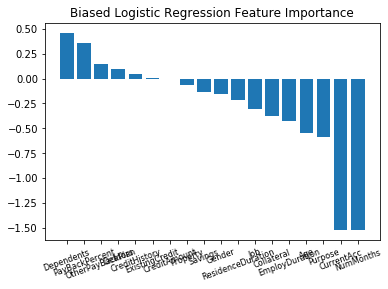

In [22]:
## CODE TO DISPLAY LOG FEATURE IMPORTANCE
# Display feature importances from the Logistic Regression Classifier
#feature_names = colnames #list(German_df.columns)

importances = biasedlogmodel.coef_[0]
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
 
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Biased Logistic Regression Feature Importance")
# Show plot
plt.show()

In [23]:
biasedrfcmodel = RandomForestClassifier(n_estimators=100,max_depth=4)
biasedrfcmodel.fit(X_train, y_train)
rfcpredictions = biasedrfcmodel.predict(X_test)
print(f"Random forest validation accuracy: {biasedrfcmodel.score(X_test, y_test)}")

Random forest validation accuracy: 0.705


In [24]:
## THIS IS MY CODE TO DISPLAY FEATURE IMPORTANCE
# List feature importances from the Random Forest Classifier
feature_importances = pd.DataFrame(biasedrfcmodel.feature_importances_, index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
NumMonths,0.194820
CreditHistory,0.188681
CreditAmount,0.155847
Savings,0.112015
Purpose,0.050812
Property,0.048376
Collateral,0.044485
EmployDuration,0.033959
PayBackPercent,0.028874
ResidenceDuration,0.026210


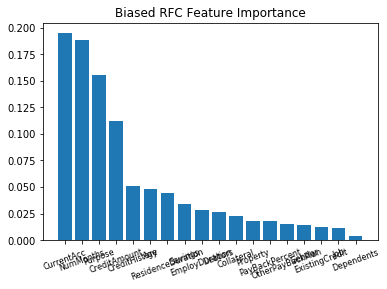

In [25]:
## THIS IS MY CODE TO DISPLAY FEATURE IMPORTANCE
# Display feature importances from the Random Forest Classifier
#feature_names = list(Adult_df.columns)

importances = biasedrfcmodel.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
 
# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Barplot: Add bars
plt.bar(range(X_train.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=20, fontsize = 8)
# Create plot title
plt.title("Biased RFC Feature Importance")
plt.show()

In [26]:
## THIS IS GARETH's CODE TO DISPLAY FEATURE IMPORTANCE
# Check for the attribute with the most impact on a random forest classification
def feature_importance(mod: Union[LogisticRegression,RandomForestClassifier],
                       names: List[str],
                       scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names,'importance': imp,
                         'std': var}).sort_values('importance',ascending=False)
def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

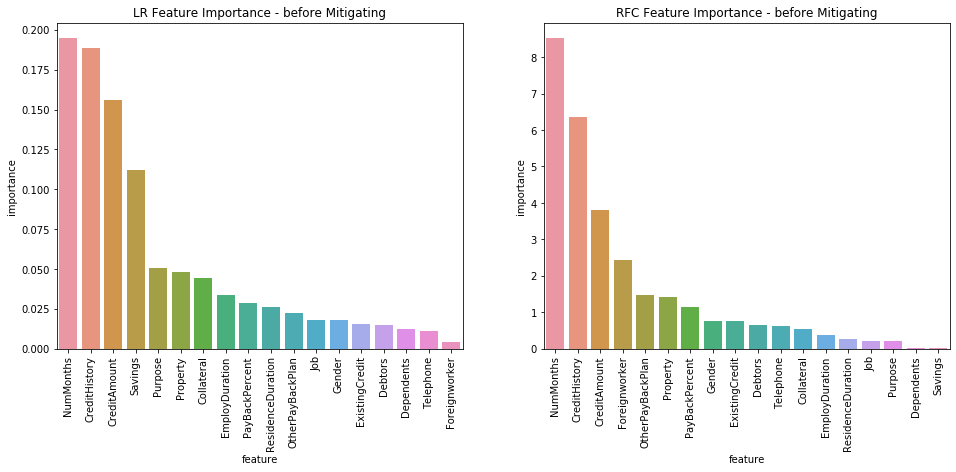

In [27]:
## THIS IS GARETH's CODE TO DISPLAY FEATURE IMPORTANCE
## THE RFC CHART (bottom right) DIFFERS FROM MINE IN CELL 22 & 23
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plot_feature_importance(x='feature',y='importance', 
                        data=feature_importance(biasedlogmodel,
                                                names=X_train.columns.tolist(),
                                                scale=X_train.std()),
                       ax=ax[1])
_ = ax[0].set_title('LR Feature Importance - before Mitigating')
plot_feature_importance(x='feature',y='importance', 
                        data=feature_importance(biasedrfcmodel,names=X_train.columns.tolist()),
                       ax=ax[0])
_ = ax[1].set_title('RFC Feature Importance - before Mitigating')